# Nonlinear Elasticity in a multipatch domain


In [63]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MHeig\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['bmat', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [64]:
p = 3   # spline degree 
n_el = (15,3)   # number of elements in y/x direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=2) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)

In [65]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.quarter_annulus().rotate_2d(3*pi/2),
    geometry.quarter_annulus().rotate_2d(pi),
    geometry.quarter_annulus().rotate_2d(pi/2)
]

patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().
MP_u = assemble.Multipatch(patches_u, automatch=True)

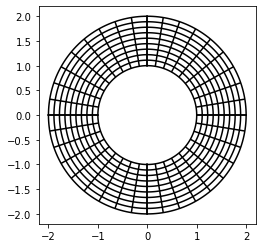

In [66]:
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [67]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset
    

In [68]:
# source term f 
def f(x, y): return (0.0, 0.0)

#Neumann BC
def gN(x, y): return (1.5e-4, -1.5e-4) 

neu_data = [
    (3,'right',gN) 
]

# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )

In [69]:
# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)
# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero )
])

In [70]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch
def get_defplot(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
   
    # restrict solution to each individual patch
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    
    # grid variables
    ref = 10
    # evaluate displacement and "pressure" over a grid in the parameter domain
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    
    figsize(10,10)
    fig, ax = plt.subplots()
    
     # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-4)
        
    colorbar();
    axis('equal')


In [71]:
# Compute solution of nonlinear elasticity problem

In [72]:
#split the solution into its components (displacement in x- and y- direction)
N = np.prod(tuple(kv.numdofs for kv in kvs_u))
def get_components(u):
    """Split solution vector into displacement components."""
    u1 = u[:N].reshape(m_u)
    u2 = u[N:2*N].reshape(m_u)
    U = np.stack((u1,u2), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


In [73]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

# nonlinear variational form
def apply_nl(dis, kvs_ux, geo_ux):
    #kvs_ux, geo_ux = MP_block.multi_patches[0].patches[3]
    #dis = get_components(u)
    z_lam = Lam* assemble.assemble('div(dis)*div(v)+ 1/2 *tr( grad(dis).T *grad(dis)) *div(v) + inner(div(dis)*grad(dis), grad(v)) + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v)) *dx'
                             , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('(inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v)) + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v))) *dx'
                                    , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(dis, kvs_ux, geo_ux):
    #kvs_ux, geo_ux = MP_block.multi_patches[0].patches[3]
    #dis = get_components(u)
    #A_lin_lam = Lam* assemble.assemble('inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) + tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) * dx'
    
    A_lin_lam1 = Lam* assemble.assemble('inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A
    A_lin_lam2 = Lam* assemble.assemble('tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A
    
    A_lin_mu = 2*Mu * assemble.assemble('inner(1/2 * grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) + (1/2) * (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + 1/2 * grad(dis)*(grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)), 1/2* (grad(v).T + grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A
    #print(A_lin_lam2)
    return A_lin_lam1 + A_lin_lam2 + A_lin_mu


In [106]:
# assemble matrix A and rhs b for nonlinear elasticity problem
def ass_nonlinsystem(u):
    first = True
    dis = get_components(u)
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]

        # The whole patch-local stiffness matrix
        A_p = linearized(dis, kvs_ux, geo_ux) # take linearized variatonal form

        # The patch-local right-hand side
        #b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() 
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(dis, kvs_ux, geo_ux) # for arbitrary rhs

        # The patch-local Neumann boundary data
        for item in neu_data:
            if item[0]==p:
                N_e   = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1])
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_e[c,i,0]

        if first:
            A = X @ A_p @ X.T
            b = X @ b_p 
            first = False
        else:
            A += X @ A_p @ X.T
            b += X @ b_p 
    
    return A, b

In [119]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(p)
dd = shape(XP)[0]
#print(dd)
#initial value
u= np.zeros(dd)
#print(u)

### first iteration ###
A, b= ass_nonlinsystem(u)
r= np.linalg.norm(A.dot(u) - b) # compute residuum
print('residual = ', r)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
u_d= solvers.make_solver(LS.A).dot(LS.b)

lv = LS.complete(LS.b)

u_d = LS.complete(u_d)
u += u_d
print(u)

# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))
#print(normed_du0)
#solutions = [LS.restrict(u)]

residual =  0.00012011330375924464
[ 0.04658729  0.0479766   0.04630974 ... -0.16741303 -0.15390643
 -0.13358144]


In [120]:
print(lv)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  0.00000000e+00 -7.12575861e-06]


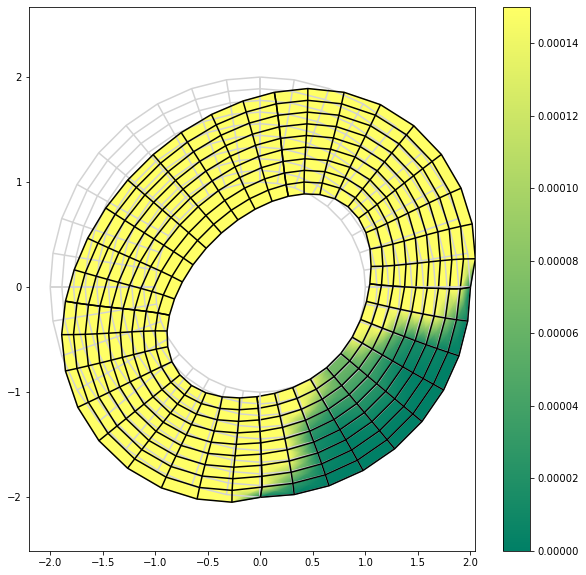

In [121]:
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)


In [122]:
# solve linearized system 

A, b= ass_nonlinsystem(u)
#b+=lv # update b: new rhs + old rhs
r= np.linalg.norm(A.dot(u) - b) # compute residuum
print('residual = ', r)
#b-= A.dot(u)

LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
u_d= solvers.make_solver(LS.A).dot(LS.b)

#lv = LS.complete(LS.b)

u_d = LS.complete(u_d)
u += u_d
print(u)

normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))

residual =  0.42856536001788464
[ 2.06851789  2.51408623  1.03514127 ... -6.42402123 -6.7901819
 -6.75797725]


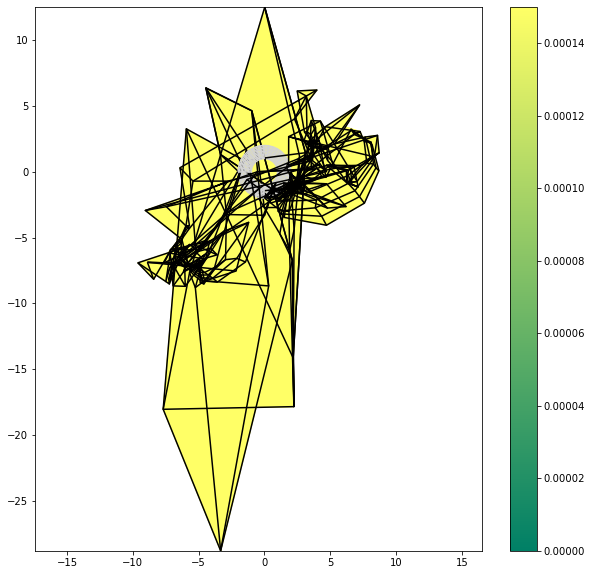

In [123]:
# print deformation plot 
get_defplot(u, patches_u, kvs_u)


2
residual =  38859.01731110227
norm(delta_u) =  6.900837175496429
step size u_d =  0.8121062618673758
3
residual =  1074.3638401538703
norm(delta_u) =  106.28944116937814
step size u_d =  99.3886039938817
4
residual =  59203207.92971899
norm(delta_u) =  107.84184897111449
step size u_d =  1.5524078017363507
5
residual =  34123.44457762064
norm(delta_u) =  7.901804140925036
step size u_d =  99.94004483018945
6
residual =  57.89511298435576
norm(delta_u) =  9.96146213643468
step size u_d =  2.0596579955096432
7
residual =  166022.49033415932
norm(delta_u) =  10.088412179957759
step size u_d =  0.12695004352307926
8
residual =  226.83231945715016
norm(delta_u) =  4.153987614600949
step size u_d =  5.93442456535681
9
residual =  11696.249970955165
norm(delta_u) =  29.563918391108572
step size u_d =  25.409930776507622
10
residual =  5060443.460548301
norm(delta_u) =  37.49950150215252
step size u_d =  7.935583111043947
[-8.18391049 -9.85157308 -9.36490818 ... -3.85700557 -2.81220134
 -3.0

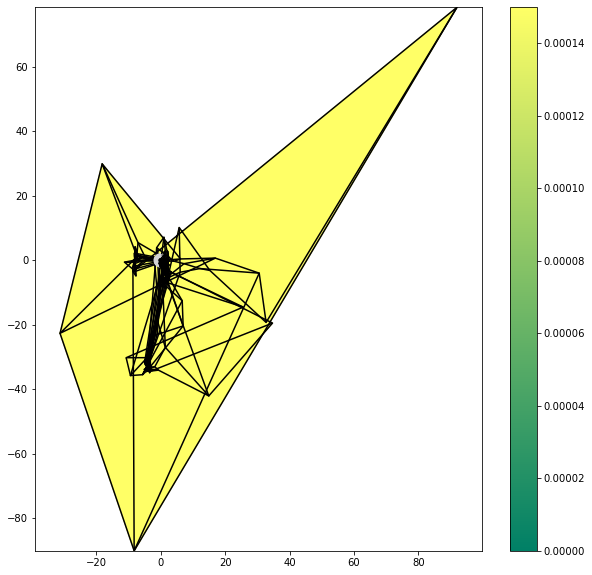

In [124]:
# solve linearized variational problem
epsilon= 1e-2
count= 1
stepsize_du1 = 1

stepsizes =[] 
ud_array = []

while True:
    count+=1
    print(count)
    # Assemble matrices and rhs in every iteration step
    A, b= ass_nonlinsystem(u)
    #b-= lv # l(v) - a(u,v)
    r= np.linalg.norm(A.dot(u) - b)
    print('residual = ', r)
    b-= A.dot(u)
   # b+=lv # update b: new rhs + old rhs
    
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    u_d = solvers.make_solver(LS.A).dot(LS.b)

    #lv = LS.complete(LS.b)
    #print('l(v) = ', lv)
    u_d = LS.complete(u_d)
    #print(u_d)
    
    #update
    u += u_d
    
    ud_array.append(u_d)
    
    normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = abs(normed_du0-normed_du)
    print('norm(delta_u) = ', normed_du)
    print ('step size u_d = ', stepsize_du)
    
    stepsizes.append(stepsize_du)
    
    if stepsize_du < epsilon:
        break
    elif stepsize_du < stepsize_du1 and stepsize_du <1e-1:
        break
    elif count == 10:
        break
        
    normed_du0 = normed_du
    stepsize_du1 = stepsize_du

# print deformation plot
get_defplot(u, patches_u, kvs_u)
print(u)

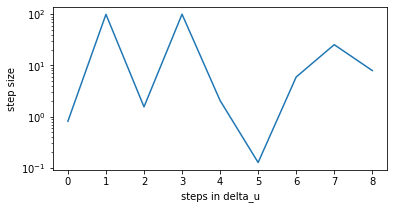

In [125]:
# plot history of step sizes
figsize(6,3)
yscale('log')
plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');